In [2]:
import pandas as pd

# Load the provided dataset
file_path = 'data/Plant_1.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()


,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


In [150]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import takewhile

# Convert DATE_TIME to datetime object and sort the data
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])
data.sort_values(by='DATE_TIME', inplace=True)

# Check for missing values
missing_values = data.isnull().sum()

# Select relevant columns
relevant_columns = ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 
                    'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'SOURCE_KEY_x']
filtered_data = data[relevant_columns]

# We will create sequences of 4 days (96 intervals of 15 minutes in a day)
sequence_length = 96 * 4

# Function to create sequences for each SOURCE_KEY
def create_sequences(input_data):
    # First, find the unique timestamps
    unique_timestamps = input_data['TIME'].unique()
    
    # Prepare a DataFrame to collect all days with complete timestamps
    complete_data = pd.DataFrame()

    # Iterate over each group, corresponding to each unique day
    for _, group in input_data.groupby('DAY'):
        # For each unique timestamp, check if it exists in the group
        for timestamp in unique_timestamps:
            if timestamp not in group['TIME'].values:
                # If a timestamp is missing, create a new row with zeros and the missing timestamp, and append it to the group
                missing_row = {'TIME': timestamp, 'DAY': group['DAY'].iloc[0]}
                for col in group.columns:
                    if col not in ['TIME', 'DAY']:
                        missing_row[col] = 0
                group = pd.concat([group, pd.DataFrame(missing_row, index=[0])], ignore_index=True)
                
        # Sort the group by TIME to ensure correct order after adding rows
        group.sort_values(by='TIME', inplace=True)
        
        # Append the completed group to the complete_data DataFrame
        complete_data = pd.concat([complete_data, group], ignore_index=True)

    # Now, create sequences of 4 consecutive days
    sequences = []
    grouped_data = complete_data.groupby('DAY')
    unique_days = complete_data['DAY'].unique()
    
    # Iterate through the unique days, making sure we have enough days left for a full sequence
    for i in range(len(unique_days) - 3):
        # Get the data for the current sequence of 4 days
        current_sequence = []
        for j in range(4):
            current_day_data = grouped_data.get_group(unique_days[i + j])
            current_sequence.append(current_day_data)
        
        # Combine the data for the 4 days into a single array and append to sequences
        sequence_data = np.vstack([day.values for day in current_sequence])
        sequences.append(sequence_data)

    return np.array(sequences)

# Process data for each SOURCE_KEY
source_keys = filtered_data['SOURCE_KEY_x'].unique()
processed_data = []
for key in source_keys[:1]: # Example for one key
    key_data = filtered_data[filtered_data['SOURCE_KEY_x'] == key].copy()
    key_data['TIME'] = key_data['DATE_TIME'].dt.hour * 3600 + key_data['DATE_TIME'].dt.minute * 60 + key_data['DATE_TIME'].dt.second
    key_data['DAY'] = key_data['DATE_TIME'].dt.dayofyear
    key_data.drop(columns=['SOURCE_KEY_x'], inplace=True)
   

    # Normalize all columns except DATE_TIME
    scaler = MinMaxScaler(feature_range=(0, 1))
    key_data.loc[:, (key_data.columns != 'DATE_TIME')] = scaler.fit_transform(key_data.loc[:, (key_data.columns != 'DATE_TIME')])
    
    # Convert DATE_TIME to numerical for sequence creation
    key_data['DATE_TIME'] = key_data['DATE_TIME'].values.astype(float)

    display(key_data.head())

    sequences = create_sequences(key_data)
    processed_data.append((key, sequences, scaler))

# Check the structure of the processed data for one of the source keys
processed_data[0][1].shape, missing_values


,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DAY
0,1.589501e+18,0.0,0.0,0.0,0.0,0.322190,0.099506,0.0,0.000000,0.0
21,1.589502e+18,0.0,0.0,0.0,0.0,0.315477,0.097484,0.0,0.010526,0.0
42,1.589503e+18,0.0,0.0,0.0,0.0,0.305457,0.093911,0.0,0.021053,0.0
63,1.589504e+18,0.0,0.0,0.0,0.0,0.299423,0.089029,0.0,0.031579,0.0
84,1.589504e+18,0.0,0.0,0.0,0.0,0.284302,0.084906,0.0,0.042105,0.0


((31, 384, 10),
 DATE_TIME              0
 PLANT_ID_x             0
 SOURCE_KEY_x           0
 DC_POWER               0
 AC_POWER               0
 DAILY_YIELD            0
 TOTAL_YIELD            0
 PLANT_ID_y             0
 SOURCE_KEY_y           0
 AMBIENT_TEMPERATURE    0
 MODULE_TEMPERATURE     0
 IRRADIATION            0
 dtype: int64)

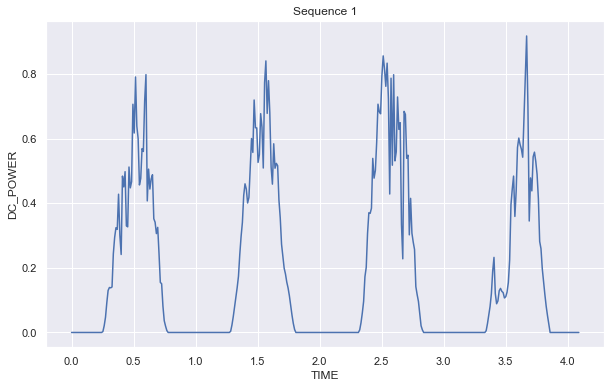

In [191]:
sequences.shape
# Plot each sequence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

for i in range(0, 1):
    plt.figure(figsize=(10, 6))
    plt.plot(sequences[i, :, 8]+sequences[i, :, 9]*34, sequences[i, :, 1])
    plt.ylabel('DC_POWER')
    plt.xlabel('TIME')
    plt.title('Sequence {}'.format(i + 1))
    plt.show()


In [192]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Split the data into training and testing sets (last 20% for testing)
train_data = {}
test_data = {}
for key, sequences, _ in processed_data:
    train_size = int(len(sequences) * 0.8)
    train_data[key] = sequences[:train_size]
    test_data[key] = sequences[train_size:]

# Define the LSTM model
def create_model():
    model = Sequential([
        LSTM(500, input_shape=(288, 10), return_sequences=True),
        Dropout(0.2),
        LSTM(500),
        Dropout(0.2),
        Dense(256),
        Dense(128),
        Dense(96)  # Output layer has 96 units for 96 time intervals
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Train the model for each SOURCE_KEY
models = {}
for key, sequences in train_data.items():
    model = create_model()
    X_train = sequences[:, :288, :]  # All features except DAILY_YIELD
    y_train = sequences[:, 288:, 1]    # Only AC Power for the 4th day
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)
    models[key] = model


Epoch 1/50


In [169]:
# Example: Test the model for one SOURCE_KEY
key = list(models.keys())[0]  # Select one SOURCE_KEY for demonstration
model = models[key]

X_test = test_data[key][:, :288, :]  # All features
y_test = test_data[key][:, 288:, 1]    # Only DC Power for the 4th day

# Generate predictions
predictions = model.predict(X_test)

# predictions now contains the predicted DAILY_YIELD for each sequence in the test data

RMSE for SOURCE_KEY 1BY6WEcLGh8j5v7: 0.11924916972443995


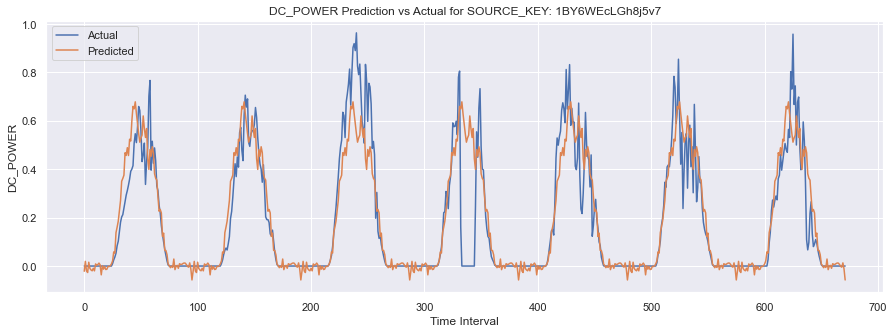

In [185]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

def plot_predictions(actual, predicted, source_key):
    plt.figure(figsize=(15, 5))
    plt.plot(actual, label='Actual')
    plt.plot(predicted, label='Predicted')
    plt.title(f'DC_POWER Prediction vs Actual for SOURCE_KEY: {source_key}')
    plt.xlabel('Time Interval')
    plt.ylabel('DC_POWER')
    plt.legend()
    plt.show()

def calculate_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# Example for one SOURCE_KEY
key = list(models.keys())[0]  # Select one SOURCE_KEY for demonstration
model = models[key]

X_test = test_data[key][:, :288, :]  # Input features for the test data
y_test = test_data[key][:, 288:, 1]    # Actual AC Power values for the test data

predictions = model.predict(X_test)

# Flatten the predictions and actual values for RMSE calculation
predictions_flat = predictions.flatten()
y_test_flat = y_test.flatten()

# Calculate RMSE
rmse = calculate_rmse(y_test_flat, predictions_flat)
print(f'RMSE for SOURCE_KEY {key}: {rmse}')

# Plot Predictions vs Actual Values
plot_predictions(y_test_flat, predictions_flat, key)




Smoothed RMSE: 0.11563233510878829


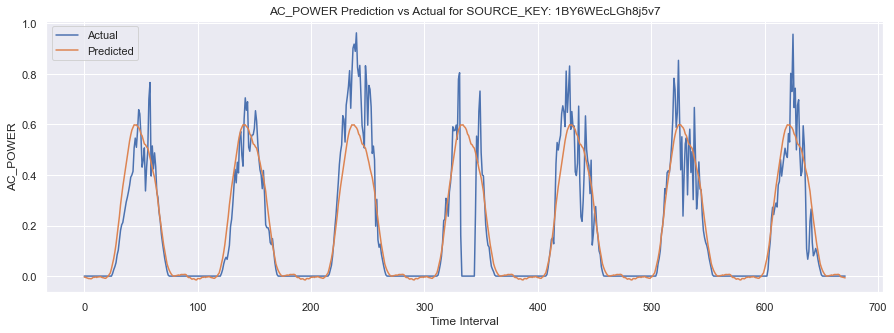

(7, 96)

In [171]:
def smooth_predictions(predictions, window_size=9):
    """Apply a simple moving average to smooth the predictions."""
    return np.convolve(predictions, np.ones(window_size)/window_size, mode='same')

# Smoothing the predictions
smoothed_predictions = smooth_predictions(predictions_flat)

# Re-calculate RMSE with smoothed predictions
smoothed_rmse = calculate_rmse(y_test_flat, smoothed_predictions)
print(f'Smoothed RMSE: {smoothed_rmse}')

# Plot Smoothed Predictions vs Actual Values
plot_predictions(y_test_flat, smoothed_predictions, key)

predictions.shape
